# Resize validation

Authors provide already resized images. Here we check whether the sizes of the given images match the values obtained by multiplying the width and height of the original images with corresponding ratios. We also check if heights of all resized images are **384** and if aspect ratio is preserved after the resizing.

In [1]:
import numpy as np
import json
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

IMG_PATH = "../data/images_384_VarV2"
with open('../data/annotation_FSC147_384.json') as json_file:
    INFO = json.load(json_file)
eps = 1e-6
ratio_eps = 1e-2

In [2]:
ratio_errors = []
resize_errors = []

for file in os.listdir(IMG_PATH):
    image = Image.open(IMG_PATH + "/" + file)
    w, h = image.size
    assert h == 384, "Ilegal height!"
    image_data = INFO[file]
    original_h, original_w = image_data["H"], image_data["W"]
    h_ratio, w_ratio = image_data["ratio_h"], image_data["ratio_w"]
    if abs(h_ratio - w_ratio) > ratio_eps:
        #print(f"Ratios are not equal! File: {file}, H ratio: {h_ratio}, W ratio: {w_ratio}")
        ratio_errors.append(file)
    if abs(original_h * h_ratio - h) > eps or (original_w * w_ratio - w) > eps:
        print(f"---------- {file} ----------")
        print(f"Resized H: {h}")
        print(f"Calculated H: {original_h*h_ratio}")
        print(f"Resized W: {w}")
        print(f"Calculated W: {original_w*w_ratio}")
        resize_errors.append(file)

In [3]:
print("Number of images with too big ratio differences:", len(ratio_errors))
print("Number of images with wrong size after rescaling:", len(resize_errors))

Number of images with too big ratio differences: 1200
Number of images with wrong size after rescaling: 0


We can see that sizes of the provided images do match the calculated sizes. However there are some images with quite a large difference between height and width ratio, suggesting that the **aspect ratio may not be preserved**.

## Ratio differences

Here we calculate the average difference (in pixels) between the widths of the given images and the widths of the images if the aspect ratios were truly preserved.

In [4]:
pixel_diff = []

for file in ratio_errors:
    img_data = INFO[file]
    # Width of the resized image calculated by authors
    actual_w = int(np.round(img_data["W"] * img_data["ratio_w"]))
    # Actual width if they kept the aspect
    correct_w = int(384 * (img_data["W"] / img_data["H"]))
    if actual_w != correct_w:
        pixel_diff.append(abs(actual_w - correct_w))

In [5]:
print("Number of images with wrong resize factor:", len(pixel_diff))
print("Average width error (in pixels):", np.mean(pixel_diff))

Number of images with wrong resize factor: 1200
Average width error (in pixels): 128.54166666666666


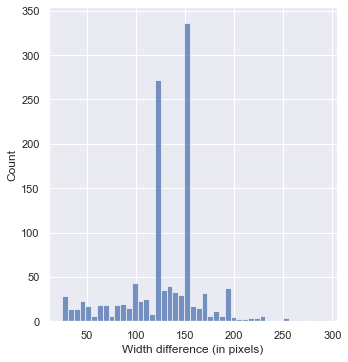

In [6]:
sns.set_theme()
fig = sns.displot(pixel_diff)
fig.set(xlabel="Width difference (in pixels)")
plt.show()

We can see that there is at least a pixel difference between given and computed width for all of the problematic images. The averrage pixel difference is around **128.5**, which is quite a large number and it is definitly interesting why authors chose different ratios. Distribution plot shows us that this high mean is not a result of some "outliers", but there is a significant difference in widths for majority of the problematic images.

### Concrete example

Here we show the difference between the two widths on a concrete example, both numerically and visually

In [7]:
print("File:", ratio_errors[0])
test_case = INFO[ratio_errors[0]]
test_case

File: 1386.jpg


{'H': 1390,
 'W': 1300,
 'box_examples_coordinates': [[[159, 147], [159, 166], [180, 166], [180, 147]],
  [[126, 197], [126, 214], [145, 214], [145, 197]],
  [[75, 244], [75, 264], [100, 264], [100, 244]]],
 'box_examples_path': ['/nfs/bigneuron/viresh/FSC_NewDataOnly/box_examples/1386_0.jpg',
  '/nfs/bigneuron/viresh/FSC_NewDataOnly/box_examples/1386_1.jpg'],
 'density_path': '/nfs/bigneuron/viresh/FSC_NewDataOnly/gt_density_map_adaptive_384_VarV2/1386.npy',
 'density_path_fixed': '/nfs/bigneuron/viresh/FSC_NewDataOnly/gt_density_map_fixed/1386.npy',
 'img_path': '/nfs/bigneuron/viresh/FSC_NewDataOnly/images_384_VarV2/1386.jpg',
 'points': [[33.48738461538461, 297.28782733812943],
  [55.96190769230769, 271.6896690647482],
  [87.68861538461537, 251.32661870503597],
  [102.2291076923077, 237.94463309352517],
  [75.13163076923077, 228.05179856115106],
  [50.6736, 232.12661870503595],
  [38.7756923076923, 247.8347050359712],
  [18.287815384615385, 239.1076834532374],
  [5.727692307692307,

In [8]:
print("Width obtained by authors:", int(np.round(test_case["W"]*test_case["ratio_w"])))
print("Width that keeps the aspect ratio the same:", int(np.round(384*(test_case["W"]/test_case["H"]))))

Width obtained by authors: 408
Width that keeps the aspect ratio the same: 359


#### Authors' image

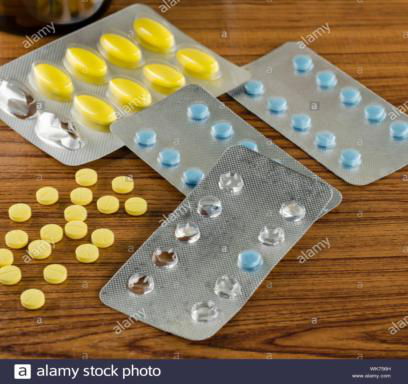

In [9]:
img = Image.open(IMG_PATH + "/" + ratio_errors[0])
img

#### Image with the correct aspect

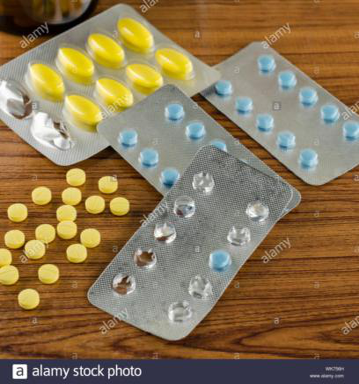

In [10]:
_, h = img.size
w = int(384*(test_case["W"]/test_case["H"]))
resized = img.resize(size = (w, h))
resized

#### Original image (resized back)

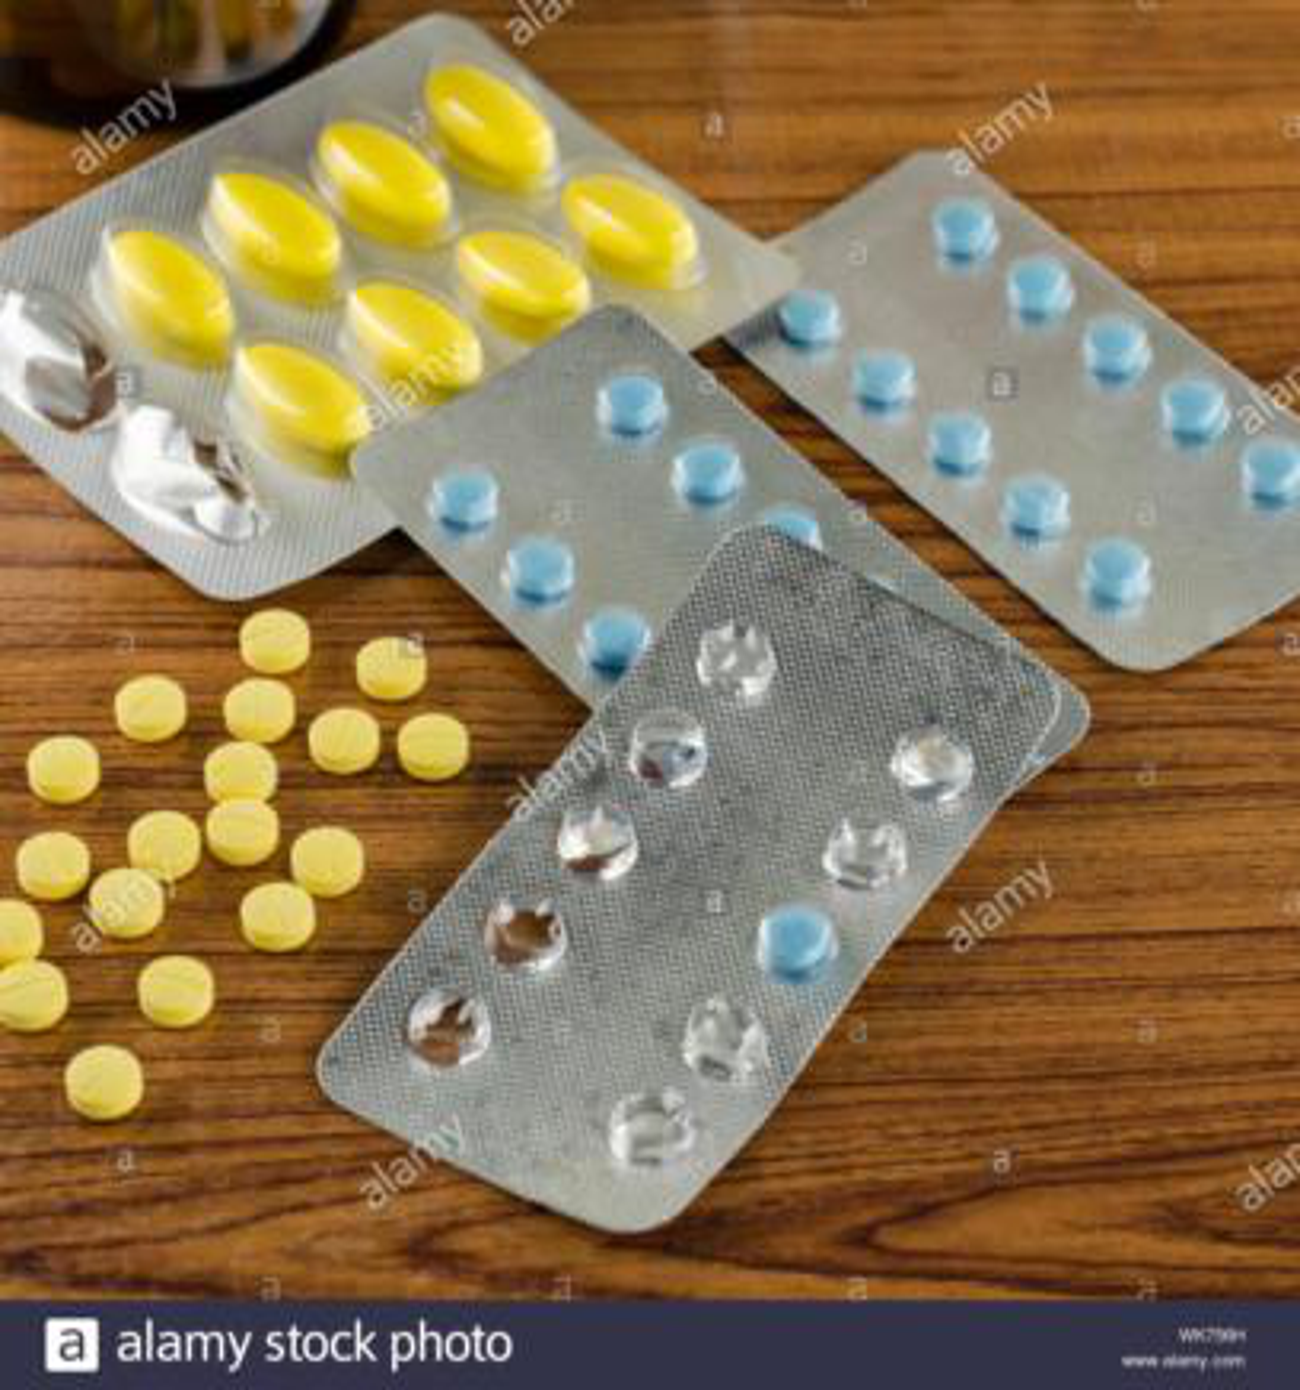

In [11]:
original = img.resize(size = (test_case["W"], test_case["H"]))
original